In [1]:
import time

In [2]:
start_time = time.time()

In [3]:
from pathlib import Path

import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import lmfit
import json
import astropy.units as u
import bfunc
import pandas as pd
import corner
from scipy import interpolate
import bplot

Input path : sf folder

In [4]:
text_file_0 = open("path-data.txt", "r")
path_data = text_file_0.read()

In [5]:
datapath_data = Path(path_data).expanduser()

Output path: results folder 

In [6]:
text_file_1 = open("path-results.txt", "r")
path_res = text_file_1.read()

In [7]:
datapath_res= Path(path_res).expanduser()

Data load and region parameters

In [8]:
data = "M8N"

In [9]:
name = "Lagoon [NII]"

In [10]:
name_in = 'FLA-M8-N'

In [11]:
data_in = json.load(open(str(datapath_data) + '/sf-' + name_in + ".json"))

In [12]:
# mask = np.array(data_in["SF"]["N pairs"]) > 0

In [13]:
B = np.array(data_in["b2"])#[mask]
r = np.array(data_in["s"])#[mask]
pc = np.array(data_in["pc"])
#pix = np.array(data_in["pix"])
box_size = np.array(data_in["box_size"])
pc_per_arcsec = pc


print("No pixels in this case")
print("Parsec per arcsec:", pc_per_arcsec)
print("Box size, parsec:", box_size)

No pixels in this case
Parsec per arcsec: 0.0060601710138692
Box size, parsec: 16.096436126419555


# Merge first K points


In [14]:
# Merge first K + 1 points
K = 1
r[K] = np.mean(r[: K + 1])
B[K] = np.mean(B[: K + 1])
r = r[K:]
B = B[K:]

Define some scales for turning points in sf

In [15]:
r_local_peak = 2.5
r_local_minimum = 4.5

Move the specification of which points to fit to be before the setting of the parameter limits.

In [16]:
relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.2 * box_size
# Define large-scale differently in this case
# weights[r > 0.5 * r_local_peak] /= 2.0
weights[large_scale] /= 2.5
weights[:16] /= 2.5

In [17]:
#to_fit = r <= r_local_minimum
to_fit = r <= 0.5 * box_size#~large_scale
#to_fit = ~large_scale

In [18]:
model = lmfit.Model(bfunc.bfunc03s)
model.param_names

['r0', 'sig2', 'm', 's0', 'noise']

Use only the points we will be fitting when determining the limits on `sig2`

In [19]:
# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2 * box_size)

# sig2 between 1/10 and 2 x max value of B(r)
model.set_param_hint(
    "sig2",
    value=0.5 * B[to_fit].max(),
    min=0.25 * B[to_fit].max(),
    max=2 * B[to_fit].max(),
)

# m between 1/2 and 5/3
model.set_param_hint("m", value=1.0, min=0.5, max=2.0)

# Seeing RMS between 0.1 and 1.5 arcsec
model.set_param_hint(
    "s0", value=0.5 * pc_per_arcsec, min=0.1 * pc_per_arcsec, max= 1.5 * pc_per_arcsec
)

# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.2 * B.min(), min=0.0, max=3.0 * B.min())

# box_size is fixed
# model.set_param_hint("box_size", value=box_size, vary=False)

In [20]:
pd.DataFrame(model.param_hints)

,r0,sig2,m,s0,noise
value,1.609644,13.373491,1.0,0.003030,0.218938
min,0.160964,6.686746,0.5,0.000606,0.000000
max,32.192872,53.493965,2.0,0.009090,3.284072


In [21]:
result = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

In [22]:
result

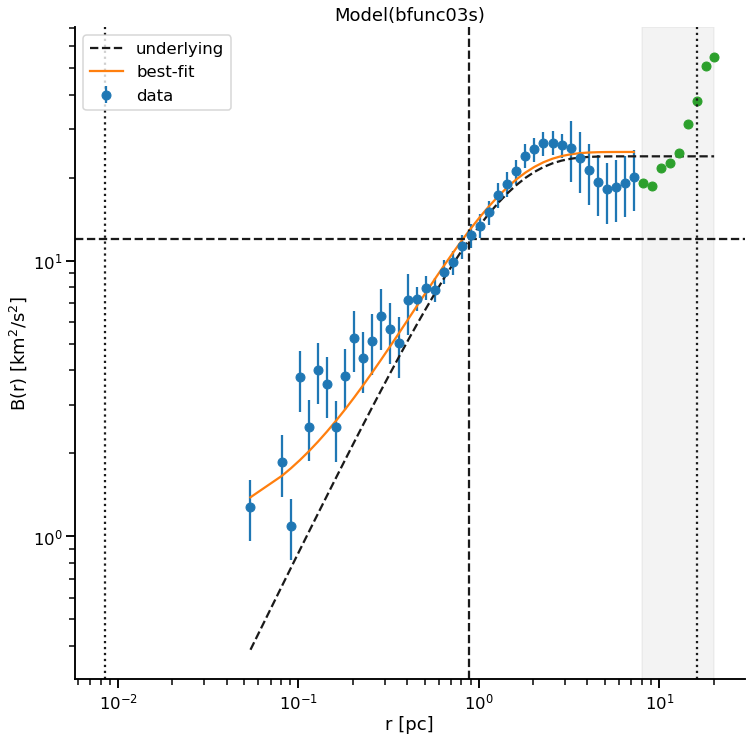

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(
    r, result.params["r0"].value, result.params["sig2"].value, result.params["m"].value
)
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result.plot_fit(ax=ax)

# Add in the points not included in fit
ax.plot(r[~to_fit], B[~to_fit], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * result.params["s0"].value, color="k", linestyle="dotted")
ax.axvline(box_size, color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(result.params["r0"].value, color="k", linestyle="dashed")
ax.axhline(result.params["sig2"].value, color="k", linestyle="dashed")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(box_size / 2, r[-1], color="k", alpha=0.05, zorder=-1)

ax.set(
    xscale="log",
    yscale="log",
    xlabel="r [pc]",
    ylabel=r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine()

emcee

In [24]:
emcee_kws = dict(
    steps=50000, burn=1000, thin=50, is_weighted=True, progress=False, workers=16
)
emcee_params = result.params.copy()
# emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

In [25]:
result_emcee = model.fit(
    data=B[to_fit],
    r=r[to_fit],
    weights=weights[to_fit],
    params=emcee_params,
    method="emcee",
    nan_policy="omit",
    fit_kws=emcee_kws,
)

In [26]:
result_emcee

Text(0, 0.5, 'acceptance fraction')

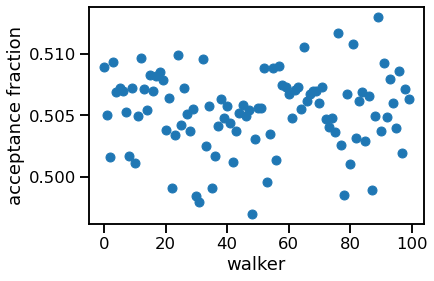

In [27]:
plt.plot(result_emcee.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance fraction")

In [28]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result_emcee.params):
        try:
            print(f"{p} = {result_emcee.acor[i]:.3f}")
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
r0 = 66.779
sig2 = 66.499
m = 69.067
s0 = 77.324
noise = 65.451


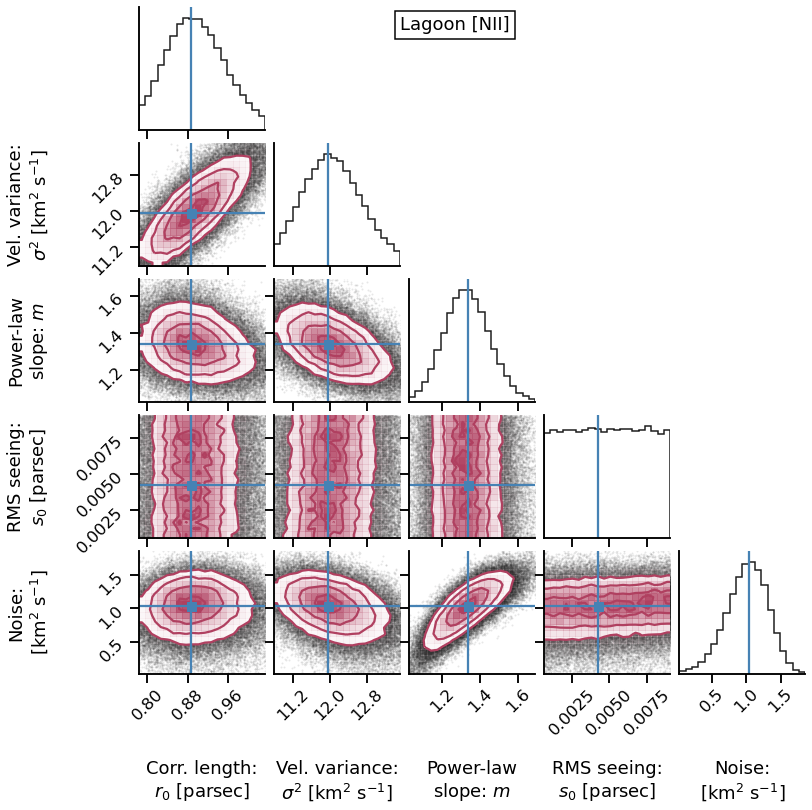

In [29]:
bplot.corner_plot(
    result_emcee, result, name, data, data_ranges=[0.95, 0.95, 0.995, 0.999, 0.999]
)
# data_ranges=[0.95, 0.99, 0.995, 0.995, 0.999]

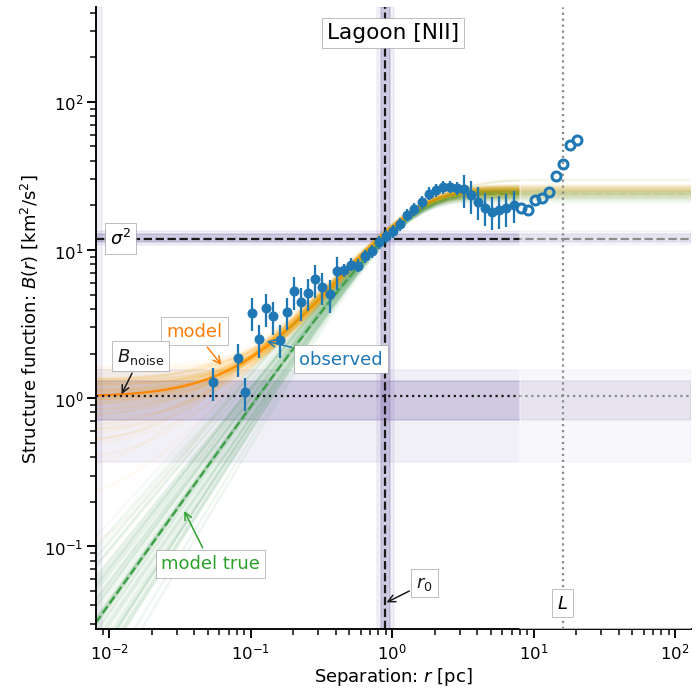

In [30]:
bplot.STYLE["data label element"] = 4
bplot.STYLE["model label element"] = 0
bplot.STYLE["model label offset"] = (-60, 40)
bplot.STYLE["true model label element"] = 7
bplot.STYLE["true model label offset"] = (30, -60)
bplot.strucfunc_plot(
    result_emcee, result, r, B, to_fit, name, data, box_size, large_scale
)

In [31]:
#bplot.strucfunc_plot(
#    result_emcee, result_emcee, r, B, to_fit, name, data, box_size, large_scale
#)

LM results

In [32]:
LM = {
    'sig2': [result.params['sig2'].value,result.params['sig2'].stderr],
    'r0': [result.params['r0'].value,result.params['r0'].stderr],
    'm' : [result.params['m'].value,result.params['m'].stderr],
    's0': [result.params['s0'].value,result.params['s0'].stderr],
    'noise' : [result.params['noise'].value,result.params['noise'].stderr]
}

In [33]:
LM

{'sig2': [11.946702926484893, 15.347838579765597],
 'r0': [0.8872073592200177, 0.08470342990960782],
 'm': [1.3397223411327612, 0.27183970819657594],
 's0': [0.004250460981136475, 1.3141067926594014],
 'noise': [1.0330193734474578, 14.518513443797932]}

MCMC results

In [34]:
MCMC = {
    'sig2': [result_emcee.params['sig2'].value,result_emcee.params['sig2'].stderr],
    'r0': [result_emcee.params['r0'].value,result_emcee.params['r0'].stderr],
    'm' : [result_emcee.params['m'].value,result_emcee.params['m'].stderr],
    's0': [result_emcee.params['s0'].value,result_emcee.params['s0'].stderr],
    'noise' : [result_emcee.params['noise'].value,result_emcee.params['noise'].stderr]
}

In [35]:
MCMC

{'sig2': [12.033592050294494, 0.6861832454779071],
 'r0': [0.8945161476954603, 0.06237594387547235],
 'm': [1.3297575240534867, 0.11959600238085277],
 's0': [0.004860308833815253, 0.0028805035045295817],
 'noise': [1.0255592254883854, 0.2993503899712984]}

MCMC 2 sigma confidence interval

In [36]:
sig2s2 = np.percentile(result_emcee.flatchain['sig2'],[2.5, 97.5])
r0s2 = np.percentile(result_emcee.flatchain['r0'],[2.5, 97.5])
ms2 = np.percentile(result_emcee.flatchain['m'],[2.5, 97.5])
s0s2 = np.percentile(result_emcee.flatchain['s0'],[2.5, 97.5])
b0s2 = np.percentile(result_emcee.flatchain['noise'],[2.5, 97.5])

In [37]:
sig2s2p = sig2s2[1]-result.params['sig2'].value
sig2s2m = result.params['sig2'].value-sig2s2[0]

r0s2p = r0s2[1]-result.params['r0'].value
r0s2m = result.params['r0'].value-r0s2[0]

ms2p = ms2[1]-result.params['m'].value
ms2m = result.params['m'].value-ms2[0]

s0s2p = s0s2[1]-result.params['s0'].value
s0s2m = result.params['s0'].value-s0s2[0]

b0s2p = b0s2[1]-result.params['noise'].value
b0s2m = result.params['noise'].value-b0s2[0]

MCMC 1 sigma confidence interval

In [38]:
sig2s1 = np.percentile(result_emcee.flatchain['sig2'],[16, 85])
r0s1 = np.percentile(result_emcee.flatchain['r0'],[16, 85])
ms1 = np.percentile(result_emcee.flatchain['m'],[16, 85])
s0s1 = np.percentile(result_emcee.flatchain['s0'],[16, 85])
b0s1 = np.percentile(result_emcee.flatchain['noise'],[16, 85])

In [39]:
sig2s1p = sig2s1[1]-result.params['sig2'].value
sig2s1m = result.params['sig2'].value-sig2s1[0]

r0s1p = r0s1[1]-result.params['r0'].value
r0s1m = result.params['r0'].value-r0s1[0]

ms1p = ms1[1]-result.params['m'].value
ms1m = result.params['m'].value-ms1[0]

s0s1p = s0s1[1]-result.params['s0'].value
s0s1m = result.params['s0'].value-s0s1[0]

b0s1p = b0s1[1]-result.params['noise'].value
b0s1m = result.params['noise'].value-b0s1[0]

LM + MCMC 2 sigma

In [40]:
results_2sig = {
    'sig2': [result.params['sig2'].value,sig2s2p,sig2s2m],
    'r0': [result.params['r0'].value,r0s2p,r0s2m],
    'm' : [result.params['m'].value,ms2p,ms2m],
    's0': [result.params['s0'].value,s0s2p,s0s2m],
    'noise' : [result.params['noise'].value,b0s2p,b0s2m] 
    
}

In [41]:
results_2sig

{'sig2': [11.946702926484893, 1.5731305033143475, 1.1673698584462429],
 'r0': [0.8872073592200177, 0.14678027591470644, 0.10472475809878112],
 'm': [1.3397223411327612, 0.23509024626610509, 0.23162821363980646],
 's0': [0.004250460981136475, 0.004628476985768921, 0.003428926358091896],
 'noise': [1.0330193734474578, 0.5198519196849669, 0.6611779743406658]}

In [42]:
results_1sig = {
    'sig2': [result.params['sig2'].value,sig2s1p,sig2s1m],
    'r0': [result.params['r0'].value,r0s1p,r0s1m],
    'm' : [result.params['m'].value,ms1p,ms1m],
    's0': [result.params['s0'].value,s0s1p,s0s1m],
    'noise' : [result.params['noise'].value,b0s1p,b0s1m] 
    
}

In [43]:
results_1sig

{'sig2': [11.946702926484893, 0.8286674085945354, 0.5681764522188253],
 'r0': [0.8872073592200177, 0.07548101991530898, 0.05172545240969606],
 'm': [1.3397223411327612, 0.11735923253086811, 0.12623189776591381],
 's0': [0.004250460981136475, 0.003550044292133875, 0.0022684041603254104],
 'noise': [1.0330193734474578, 0.2837753352779262, 0.3231396772877605]}

In [44]:
observations ={
    'obs':data_in,
#    'vv':data_in['VF'],
#    'ss':data_in['VF']['ss']
    
}

In [45]:
properties = {
 #   'pix' : data_in['pix'],
    'pc' : data_in['pc'],
    'box_size' : data_in['box_size']
}

In [46]:
fit_results = {
    'name' : name_in,
    'results_1sig' : results_1sig,
    'results_2sig' : results_2sig,
    'LM':LM,
    'MCMC':MCMC,
    'properties' : properties,
    'B' : B,
    'r' : r,
     'preres' : data_in['results'],
     'SFresults' : data_in['SF'],
    'observations' : observations
    
}

In [47]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [48]:
jsonfilename =name_in +".json"
with open(datapath_res/jsonfilename, "w") as f:
    json.dump(fit_results, fp=f, indent=3, cls=MyEncoder)

In [49]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 401.80135202407837 seconds ---


In [50]:
!jupyter nbconvert --to script --no-prompt ci-FLA-M8-N.ipynb

[NbConvertApp] Converting notebook ci-FLA-M8-N.ipynb to script
[NbConvertApp] Writing 9489 bytes to ci-FLA-M8-N.py
